In [42]:
import numpy as np   ## linear algebra
import pandas as pd  ## data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split  ## split train and test
from IPython.display import display ## Allows the use of display() for DataFrames
import seaborn as sns
color = sns.color_palette()

import matplotlib.pyplot as plt  ## data visualization
%matplotlib inline

import gc   ## clean up 
import time ## time it

from subprocess import check_output
print(check_output(["ls", "./data"]).decode("utf8"))
# Any results you write to the current directory are saved as output.

aisles.csv
departments.csv
order_products__prior.csv
order_products__train.csv
orders.csv
products.csv
sample_submission.csv



In [2]:
def load_data(path_data):
    '''
    --------------------------------order_product--------------------------------
    * Unique in order_id + product_id
    '''
    priors = pd.read_csv(path_data + 'order_products__prior.csv', 
                     dtype={
                            'order_id': np.int32,
                            'product_id': np.uint16,
                            'add_to_cart_order': np.int16,
                            'reordered': np.int8})
    train = pd.read_csv(path_data + 'order_products__train.csv', 
                    dtype={
                            'order_id': np.int32,
                            'product_id': np.uint16,
                            'add_to_cart_order': np.int16,
                            'reordered': np.int8})
    '''
    --------------------------------order--------------------------------
    * This file tells us which set (prior, train, test) an order belongs
    * Unique in order_id
    * order_id in train, prior, test has no intersection
    * this is the #order_number order of this user
    '''
    orders = pd.read_csv(path_data + 'orders.csv', 
                         dtype={
                                'order_id': np.int32,
                                'user_id': np.int64,
                                'eval_set': 'category',
                                'order_number': np.int16,
                                'order_dow': np.int8,
                                'order_hour_of_day': np.int8,
                                'days_since_prior_order': np.float32})
    '''
    --------------------------------product--------------------------------
    * Unique in product_id
    '''
    products = pd.read_csv(path_data + 'products.csv')
    aisles = pd.read_csv(path_data + "aisles.csv")
    departments = pd.read_csv(path_data + "departments.csv")
    sample_submission = pd.read_csv(path_data + "sample_submission.csv")
    
    return priors, train, orders, products, aisles, departments, sample_submission


In [26]:
path_data = './data/'
df_priors, df_train, df_orders, df_products, df_aisles, df_departments, df_sample_submission = load_data(path_data)    

In [4]:
## Suggested by @Robert Goss https://www.kaggle.com/nickycan/lb-0-3805009-python-edition
import sys

def check_data(data):
    starting_size = sys.getsizeof(data)
    i = 0
    for c, dtype in zip(data.columns, data.dtypes):
        if 'int' in str(dtype):
            if min(data[c]) >=0:
                max_int =  max(data[c])
                if max_int <= 255:
                    data[c] = data[c].astype(np.uint8)
                elif max_int <= 65535:
                    data[c] = data[c].astype(np.uint16)
                elif max_int <= 4294967295:
                    data[c] = data[c].astype(np.uint32)
                i += 1
    print("Number of colums adjusted: {}\n".format(i))
    ## Changing known reorderd col to smaller int size
    data['reordered'] = np.nan_to_num(data['reordered']).astype(np.uint8)
    data.reordered.loc[data['reordered'] == 0] = np.nan  ## only replace such element in the column
    print("Reduced size {:.2%}".format(float(sys.getsizeof(data))/float(starting_size)))
    return data

In [5]:
my_check_list = [df_priors, df_train]
for this in my_check_list:
    check_data(this)
    

Number of colums adjusted: 4



/Users/udothemath1984/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Reduced size 166.67%
Number of colums adjusted: 4

Reduced size 166.67%


### The data is ready. ###

In [6]:
## df_priors, df_train, df_orders, df_products, df_aisles, df_departments, df_sample_submission

In [7]:
# Quick peak on the dataset
print ("aisles")
print (df_aisles.shape)
display(df_aisles.head(n=5))
print ("-"*50)

print ("departments")
print (df_departments.shape)
display(df_departments.head(n=5))
print ("-"*50)

print ("order_products__prior")
print (df_priors.shape)
display(df_priors.head(n=5))
print ("-"*50)

print ("order_products__train")
print (df_train.shape)
display(df_train.head(n=5))
print ("-"*50)

print ("orders")
print (df_orders.shape)
display(df_orders.head(n=5))
print ("-"*50)

print ("products")
print (df_products.shape)
display(df_products.tail(n=5))
print ("-"*50)

print ("sample_submission")
print (df_sample_submission.shape)
display(df_sample_submission.tail(n=5))
print ("-"*50)


aisles
(134, 2)


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


--------------------------------------------------
departments
(21, 2)


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


--------------------------------------------------
order_products__prior
(32434489, 4)


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1.0
1,2,28985,2,1.0
2,2,9327,3,NaN
3,2,45918,4,1.0
4,2,30035,5,NaN


--------------------------------------------------
order_products__train
(1384617, 4)


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1.0
1,1,11109,2,1.0
2,1,10246,3,NaN
3,1,49683,4,NaN
4,1,43633,5,1.0


--------------------------------------------------
orders
(3421083, 7)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


--------------------------------------------------
products
(49688, 4)


,product_id,product_name,aisle_id,department_id
49683,49684,"Vodka, Triple Distilled, Twist of Vanilla",124,5
49684,49685,En Croute Roast Hazelnut Cranberry,42,1
49685,49686,Artisan Baguette,112,3
49686,49687,Smartblend Healthy Metabolism Dry Cat Food,41,8
49687,49688,Fresh Foaming Cleanser,73,11


--------------------------------------------------
sample_submission
(75000, 2)


,order_id,products
74995,3420740,39276 29259
74996,3420877,39276 29259
74997,3420888,39276 29259
74998,3420989,39276 29259
74999,3421054,39276 29259


--------------------------------------------------


In [8]:
my_data_files = [df_aisles,
                 df_departments,
                 df_priors,
                 df_train,
                 df_orders,
                 df_products,
                 df_sample_submission]

for check_this in my_data_files:
    print ("-"*50)
    print(check_this.head(4).to_latex())



--------------------------------------------------
\begin{tabular}{lrl}
\toprule
{} &  aisle\_id &                  aisle \\
\midrule
0 &         1 &  prepared soups salads \\
1 &         2 &      specialty cheeses \\
2 &         3 &    energy granola bars \\
3 &         4 &          instant foods \\
\bottomrule
\end{tabular}

--------------------------------------------------
\begin{tabular}{lrl}
\toprule
{} &  department\_id & department \\
\midrule
0 &              1 &     frozen \\
1 &              2 &      other \\
2 &              3 &     bakery \\
3 &              4 &    produce \\
\bottomrule
\end{tabular}

--------------------------------------------------
\begin{tabular}{lrrrr}
\toprule
{} &  order\_id &  product\_id &  add\_to\_cart\_order &  reordered \\
\midrule
0 &         2 &       33120 &                  1 &        1.0 \\
1 &         2 &       28985 &                  2 &        1.0 \\
2 &         2 &        9327 &                  3 &        NaN \\
3 &         2 &    

In [9]:
# combine aisles, departments and products (left joined to products)
df_goods = pd.merge(left=pd.merge(left=df_products, right=df_departments, how='left'), right=df_aisles, how='left')
# to retain '_' and make product names more "standard"
df_goods.product_name = df_goods.product_name.str.replace(' ', '_').str.lower() 

print ("Dimension: {}".format(df_goods.shape))
df_goods.head()

Dimension: (49688, 6)


,product_id,product_name,aisle_id,department_id,department,aisle
0,1,chocolate_sandwich_cookies,61,19,snacks,cookies cakes
1,2,all-seasons_salt,104,13,pantry,spices seasonings
2,3,robust_golden_unsweetened_oolong_tea,94,7,beverages,tea
3,4,smart_ones_classic_favorites_mini_rigatoni_wit...,38,1,frozen,frozen meals
4,5,green_chile_anytime_sauce,5,13,pantry,marinades meat preparation


In [10]:
print(df_goods.head(4).to_latex())


\begin{tabular}{lrlrrll}
\toprule
{} &  product\_id &                                       product\_name &  aisle\_id &  department\_id & department &              aisle \\
\midrule
0 &           1 &                         chocolate\_sandwich\_cookies &        61 &             19 &     snacks &      cookies cakes \\
1 &           2 &                                   all-seasons\_salt &       104 &             13 &     pantry &  spices seasonings \\
2 &           3 &               robust\_golden\_unsweetened\_oolong\_tea &        94 &              7 &  beverages &                tea \\
3 &           4 &  smart\_ones\_classic\_favorites\_mini\_rigatoni\_wit... &        38 &              1 &     frozen &       frozen meals \\
\bottomrule
\end{tabular}



### Exploratory Visualization ###

department
personal care    6563
snacks           6264
pantry           5371
beverages        4365
frozen           4007
Name: product_id, dtype: int64

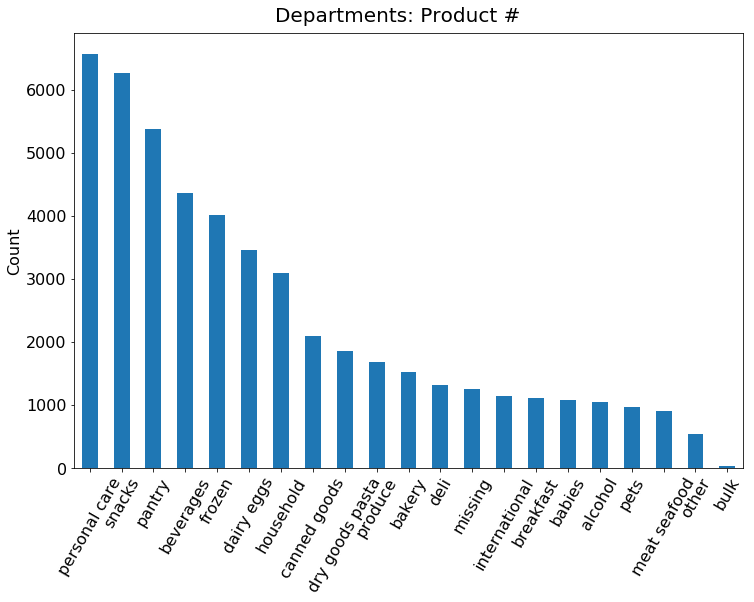

In [11]:
# basic group info (departments)
display(df_goods.groupby(['department']).count()['product_id'].copy()\
.sort_values(ascending=False).head())

fig = plt.figure(figsize=(12, 8))

plt.clf()
df_goods.groupby(['department']).count()['product_id'].copy()\
.sort_values(ascending=False).plot(kind='bar', 
                                   fontsize=16, rot=60)

plt.figtext(.5,.9,'Departments: Product #', fontsize=20, ha='center')  ## arbitrary position
plt.xlabel('', fontsize=16)
plt.ylabel('Count', fontsize=16)

plt.show()

fig.savefig('./figures/fig_dep_prod.png', dpi=fig.dpi, bbox_inches='tight')
#fig.savefig('./figures/temp2.png', dpi=fig.dpi, bbox_inches='tight', pad_inches=0.5)

### Number of items in top-15 aisles ###

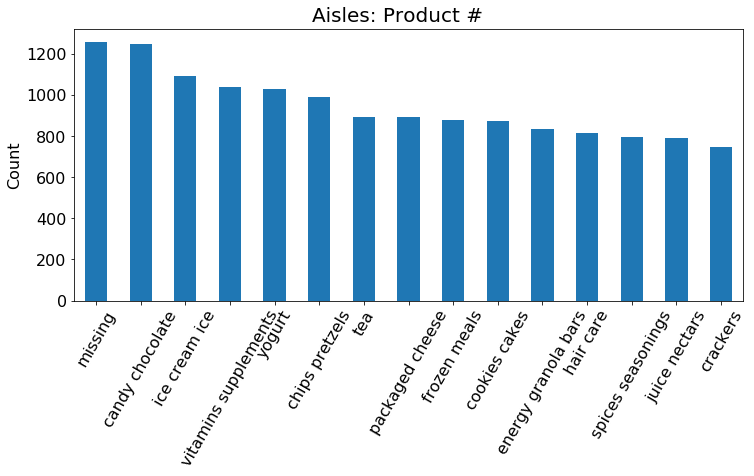

In [12]:
# basic group info (top-x aisles)
top_aisles_cnt = 15
fig = plt.figure(figsize=(12, 5))
df_goods.groupby(['aisle']).count()['product_id']\
.sort_values(ascending=False)[:top_aisles_cnt].plot(kind='bar', 
                                   fontsize=16, rot = 60)

plt.figtext(.5,.9,'Aisles: Product #', fontsize=20, ha='center')  ## arbitrary position
plt.xlabel('', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.show()
fig.savefig('./figures/fig_aisles_prod.png', dpi=fig.dpi, bbox_inches='tight')


### Item count in each department within different aisles ###

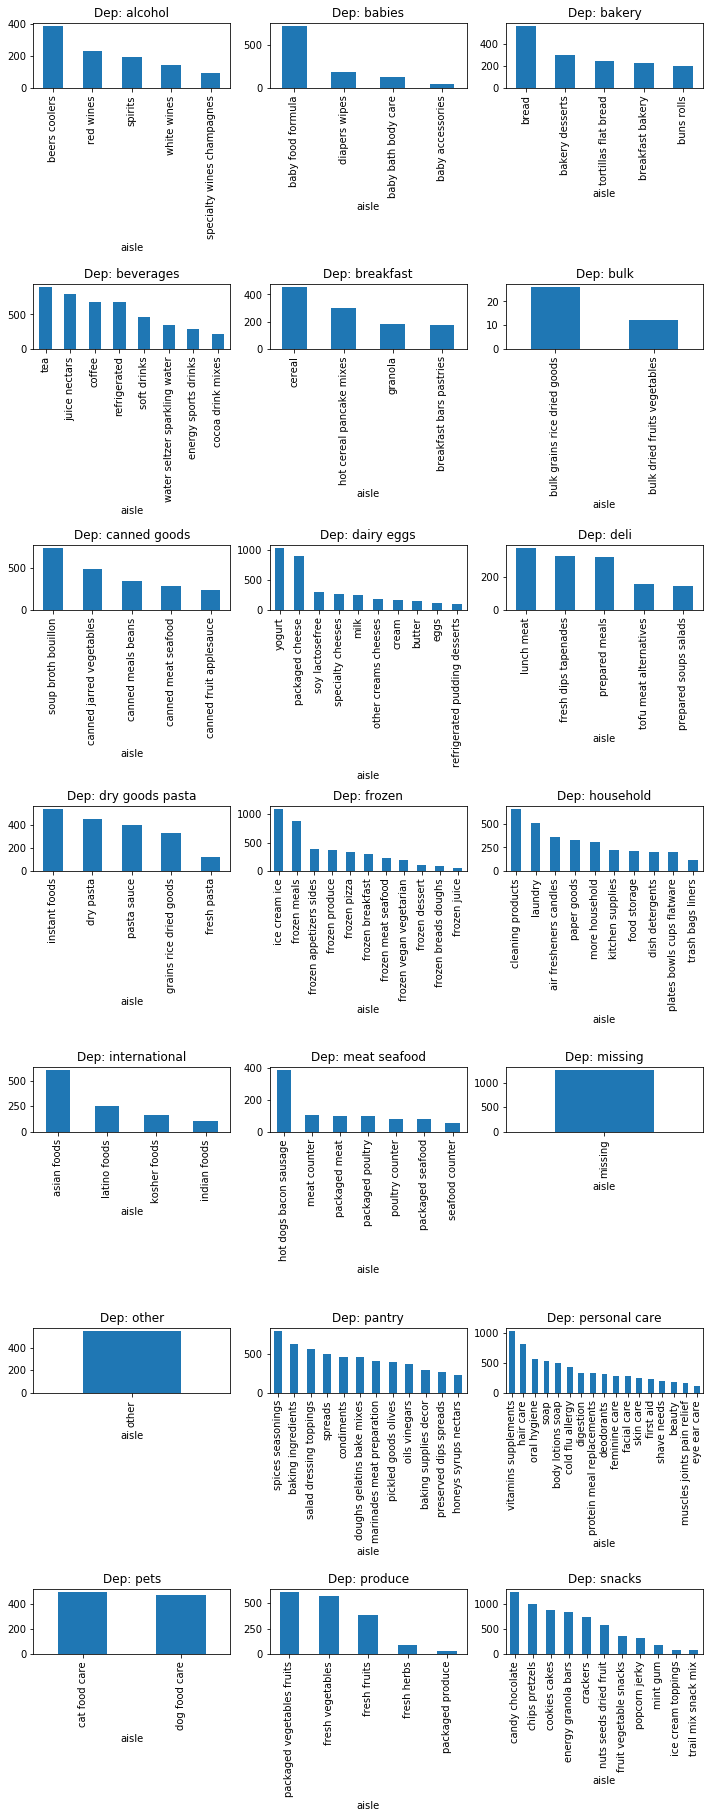

In [13]:
## plot departments volume, split by aisles
f, axarr = plt.subplots(7, 3, figsize=(12, 30))
## i is the index for locating the position of the plot
## e is the name of department
for i,e in enumerate(df_departments.department.sort_values(ascending=True)):
    ## where i//4 means integer division, i%4 means modulo
    axarr[i//3, i%3].set_title('Dep: {}'.format(e))
    df_goods[df_goods.department==e].groupby(['aisle']).count()['product_id']\
    .sort_values(ascending=False).plot(kind='bar', ax=axarr[i//3, i%3])
f.subplots_adjust(hspace=3)
plt.show()
f.savefig('./figures/fig_dep_aisles_count.png', dpi=fig.dpi, bbox_inches='tight', pad_inches=0.5)


### Day of The Week and Hour of The Day ###

**What day most people buy in a week, in a day?**

Because we want to predict the previously purchased items that buyer will buy again in the future, such information could be strongly relevant to buyers' behavior and could be strongly correlated to the prediction.

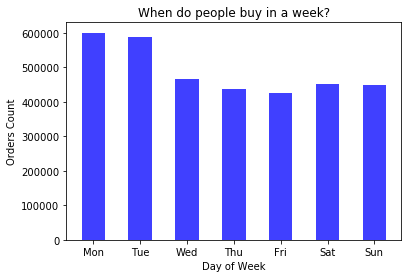

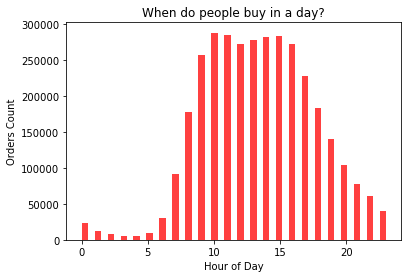

In [14]:
#df_orders.order_dow.unique()
#plt.clf()
fig, ax = plt.subplots()
labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

## 13 comes from 2 * 7 - 1
n, bins, patches = plt.hist(df_orders.order_dow, 13, facecolor="blue",
                            alpha=.75, label = labels, align='mid')

#print (n, bins, patches)

plt.xlabel("Day of Week")

width= (bins[2] - bins[1])
ax.set_xticks(bins[::2]+width/2)  ## set xtick every other position + half of the width
ax.set_xticklabels(labels)

plt.ylabel("Orders Count")
plt.title("When do people buy in a week?")

plt.show()
fig.savefig('./figures/fig_shop_in_week.png', dpi=fig.dpi, bbox_inches='tight')


## In a day
##df_orders.order_hour_of_day.unique()
##plt.clf()

fig, ax = plt.subplots()
## 47 comes from 24 * 2 -1
n_of_grid = 48
n, bins, patch = plt.hist(df_orders.order_hour_of_day, n_of_grid - 1, facecolor="red", alpha=.75, align='mid')

plt.xlabel("Hour of Day")
plt.ylabel("Orders Count")
plt.title("When do people buy in a day?")

plt.show()
fig.savefig('./figures/fig_shop_in_day.png', dpi=fig.dpi, bbox_inches='tight')


Throughout the week, lots of orders were placed in Monday and Tuesday, about 33% more than the other days. Throughout the day, the most popular shopping time is 9 to 5, which is **the same** as the regular business hours. Probably it is easier to reach the laptop, connect to the Internet, and buy something **important** for the household when you are at work.


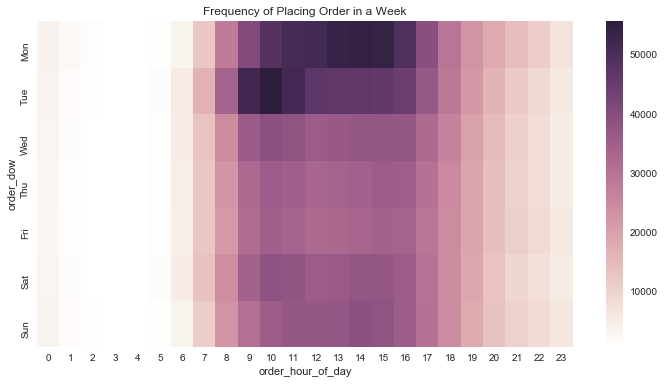

In [57]:
## https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-instacart
df_grouped = df_orders.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
df_grouped = df_grouped.pivot('order_dow', 'order_hour_of_day', 'order_number')

fig, ax = plt.subplots(figsize=(12,6))

cmap = sns.cubehelix_palette(light=1, as_cmap=True)

##cmap = sns.light_palette((210, 90, 60), input="husl", as_cmap=True)
##cmap = sns.dark_palette("palegreen", as_cmap=True)

sns.heatmap(df_grouped, yticklabels= ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], 
            cmap=cmap)
plt.title("Frequency of Placing Order in a Week")
plt.show()

fig.savefig('./figures/fig_shoptime_heatmap.png', dpi=fig.dpi, bbox_inches='tight')


### Number of items in your shopper cart ###

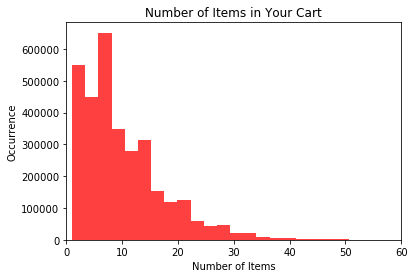

In [15]:
## number of items per order

fig, ax = plt.subplots()

n, bins, patches = plt.hist(df_priors.groupby('order_id')['add_to_cart_order'].max(), 61, facecolor="red", alpha=.75, align='mid')
plt.xlim( (0, 60) )  # set the xlim to xmin, xmax

plt.xlabel("Number of Items")
plt.ylabel("Occurrence")
plt.title("Number of Items in Your Cart")

plt.show()
fig.savefig('./figures/fig_item_per_order.png', dpi=fig.dpi, bbox_inches='tight')


In [16]:
print(df_priors.groupby('order_id')['add_to_cart_order'].max().value_counts().nlargest(10))

5     228330
6     227675
4     222081
7     220006
3     207027
8     203374
2     186993
9     184347
10    165550
1     156748
Name: add_to_cart_order, dtype: int64


In [17]:
## Most frequent ordered items
display(df_priors.head(5))

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1.0
1,2,28985,2,1.0
2,2,9327,3,NaN
3,2,45918,4,1.0
4,2,30035,5,NaN


In [18]:
## https://pandas.pydata.org/pandas-docs/stable/merging.html
df_tmp = df_priors.groupby('product_id')['add_to_cart_order'].count().to_frame().reset_index()
df_freq_order = pd.merge(df_products, pd.DataFrame(df_tmp, columns=['product_id','add_to_cart_order']), 
                  on='product_id')
df_freq_order.sort_values('add_to_cart_order', ascending=False).head(n=5)

,product_id,product_name,aisle_id,department_id,add_to_cart_order
24848,24852,Banana,24,4,472565
13172,13176,Bag of Organic Bananas,24,4,379450
21133,21137,Organic Strawberries,24,4,264683
21899,21903,Organic Baby Spinach,123,4,241921
47198,47209,Organic Hass Avocado,24,4,213584


In [19]:
print(df_freq_order.sort_values('add_to_cart_order', ascending=False).head(n=5).to_latex())


\begin{tabular}{lrlrrr}
\toprule
{} &  product\_id &            product\_name &  aisle\_id &  department\_id &  add\_to\_cart\_order \\
\midrule
24848 &       24852 &                  Banana &        24 &              4 &             472565 \\
13172 &       13176 &  Bag of Organic Bananas &        24 &              4 &             379450 \\
21133 &       21137 &    Organic Strawberries &        24 &              4 &             264683 \\
21899 &       21903 &    Organic Baby Spinach &       123 &              4 &             241921 \\
47198 &       47209 &    Organic Hass Avocado &        24 &              4 &             213584 \\
\bottomrule
\end{tabular}



### Have you order the same item before? ###

In [29]:
## fillna if there are NaN in the entry
df_reordered_prod_prior = pd.DataFrame({'count' : df_priors.groupby( ['reordered'] ).size()}).reset_index()

df_reordered_prod_prior['ratio'] = df_reordered_prod_prior['count']/ df_reordered_prod_prior['count'].sum()
display(df_reordered_prod_prior)

,reordered,count,ratio
0,0,13307953,0.410303
1,1,19126536,0.589697


In [30]:
print(df_reordered_prod_prior.to_latex())


\begin{tabular}{lrrr}
\toprule
{} &  reordered &     count &     ratio \\
\midrule
0 &          0 &  13307953 &  0.410303 \\
1 &          1 &  19126536 &  0.589697 \\
\bottomrule
\end{tabular}



### Most frequent re-ordered item ###

In [33]:
df_id_re_0or1_count = pd.DataFrame({'count' : df_priors.groupby([ "product_id", "reordered"] ).size()}).reset_index()

In [34]:
display(df_id_re_0or1_count.sort_values('count', ascending=False).head(6))

,product_id,reordered,count
47529,24852,1,398609
25170,13176,1,315913
40416,21137,1,205845
41873,21903,1,186884
90247,47209,1,170131
91308,47766,1,134044


In [35]:
## for total
## df_id_tot_count = df_id_re_0or1_count.groupby('product_id')['count'].agg(['sum']).rename(columns={'sum': 'tot_count'}).reset_index()
## print (df_id_tot_count.head(20))

## for specific items
## print (df_train.loc[df_train['product_id'].isin([2,3])])

df_id_re_tot = df_id_re_0or1_count.assign(reordered = df_id_re_0or1_count['reordered'] * df_id_re_0or1_count['count'])\
 .groupby('product_id', as_index=False).sum()

df_id_re_tot['rate'] = np.round(df_id_re_tot['reordered'] / df_id_re_tot['count'], 3 )
    
display(df_id_re_tot.head(6))
df_id_re_tot.describe()

,product_id,reordered,count,rate
0,1,1136,1852,0.613
1,2,12,90,0.133
2,3,203,277,0.733
3,4,147,329,0.447
4,5,9,15,0.600
5,6,3,8,0.375


,product_id,reordered,count,rate
count,49677.000000,49677.000000,49677.000000,49677.000000
mean,24843.417356,385.017936,652.907563,0.366463
std,14343.034804,3601.713646,4792.114416,0.208101
min,1.000000,0.000000,1.000000,0.000000
25%,12423.000000,4.000000,17.000000,0.208000
50%,24842.000000,22.000000,60.000000,0.377000
75%,37264.000000,115.000000,260.000000,0.529000
max,49688.000000,398609.000000,472565.000000,0.941000


In [36]:
display(df_id_re_tot.copy().sort_values('rate', ascending=False)[:5])
display(df_id_re_tot.copy().sort_values('count', ascending=False)[:5])

,product_id,reordered,count,rate
6430,6433,64,68,0.941
2074,2075,81,87,0.931
43545,43553,12,13,0.923
27734,27740,93,101,0.921
14605,14609,32,35,0.914


,product_id,reordered,count,rate
24848,24852,398609,472565,0.844
13172,13176,315913,379450,0.833
21133,21137,205845,264683,0.778
21899,21903,186884,241921,0.773
47198,47209,170131,213584,0.797


Among these orders, there are 49677 different products from the 49688 product category. Item id 6433 has the highest re-ordered rate (94.1%), followed by item #2075 (93.1%), and item #43553 (92.3%). If we count the number of times the products being re-ordered, item #24852 is 472565 times, followed by #13172 (379450 times) and #21137 (264683 times). So you might wonder, what are these items?

In [37]:
## merge two df, list item info
df_product_id = pd.merge(df_id_re_tot, df_products, on='product_id', how='left')

display(df_product_id.copy().sort_values('rate', ascending=False)[:5])
display(df_product_id.copy().sort_values('count', ascending=False)[:5])


,product_id,reordered,count,rate,product_name,aisle_id,department_id
6430,6433,64,68,0.941,Raw Veggie Wrappers,13,20
2074,2075,81,87,0.931,Serenity Ultimate Extrema Overnight Pads,126,11
43545,43553,12,13,0.923,Orange Energy Shots,64,7
27734,27740,93,101,0.921,Chocolate Love Bar,45,19
14605,14609,32,35,0.914,Soy Powder Infant Formula,92,18


,product_id,reordered,count,rate,product_name,aisle_id,department_id
24848,24852,398609,472565,0.844,Banana,24,4
13172,13176,315913,379450,0.833,Bag of Organic Bananas,24,4
21133,21137,205845,264683,0.778,Organic Strawberries,24,4
21899,21903,186884,241921,0.773,Organic Baby Spinach,123,4
47198,47209,170131,213584,0.797,Organic Hass Avocado,24,4


In [38]:
print(df_product_id.sort_values('rate', ascending=False)[:5].to_latex())


\begin{tabular}{lrrrrlrr}
\toprule
{} &  product\_id &  reordered &  count &   rate &                              product\_name &  aisle\_id &  department\_id \\
\midrule
6430  &        6433 &         64 &     68 &  0.941 &                       Raw Veggie Wrappers &        13 &             20 \\
2074  &        2075 &         81 &     87 &  0.931 &  Serenity Ultimate Extrema Overnight Pads &       126 &             11 \\
43545 &       43553 &         12 &     13 &  0.923 &                       Orange Energy Shots &        64 &              7 \\
27734 &       27740 &         93 &    101 &  0.921 &                        Chocolate Love Bar &        45 &             19 \\
14605 &       14609 &         32 &     35 &  0.914 &                 Soy Powder Infant Formula &        92 &             18 \\
\bottomrule
\end{tabular}



In [39]:
print(df_product_id.sort_values('count', ascending=False)[:5].to_latex())


\begin{tabular}{lrrrrlrr}
\toprule
{} &  product\_id &  reordered &   count &   rate &            product\_name &  aisle\_id &  department\_id \\
\midrule
24848 &       24852 &     398609 &  472565 &  0.844 &                  Banana &        24 &              4 \\
13172 &       13176 &     315913 &  379450 &  0.833 &  Bag of Organic Bananas &        24 &              4 \\
21133 &       21137 &     205845 &  264683 &  0.778 &    Organic Strawberries &        24 &              4 \\
21899 &       21903 &     186884 &  241921 &  0.773 &    Organic Baby Spinach &       123 &              4 \\
47198 &       47209 &     170131 &  213584 &  0.797 &    Organic Hass Avocado &        24 &              4 \\
\bottomrule
\end{tabular}



By considering the reordered rate, the top three items are Raw Veggie Wrappers, Serenity Ultimate Extrema Overnight Pads, and Orange Energy Shots. It is some type of indication that the customer are satisfied with their purchase. However, we should always re-evaluate the value, or the number, in a certain angle that the information is "truly" revealed. For instance, we directly show that the highest re-ordered rate without considering total number of the purchase. The top rated raw veggie wrappers only has 68 order history, is it a good representation of satisfactory rate over the entire dataset? Therefore, we output the results showing the top 5 re-ordered items by number, which are banana, bag of organic bananas, organic strawberries, organic baby spinach, and organic hass avocado. These items contain more than 200K order history. Among these the re-ordered rates are in the range around 80%. Therefore, second representation of counting the re-ordered occurrences and rate might be more robust of concluding the most popular re-ordered items.

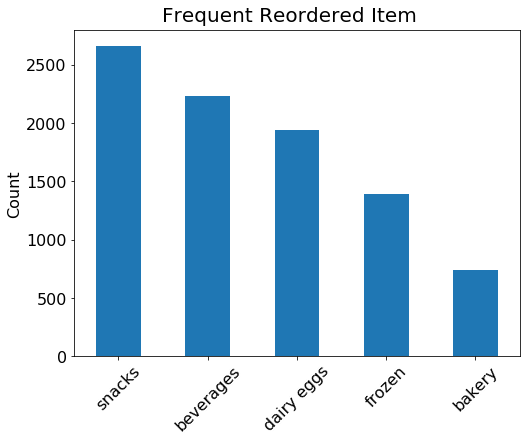

In [41]:
df_dep_count = pd.DataFrame(df_product_id[df_product_id['rate'] > 0.5 ]['department_id']\
                                    .value_counts(sort=True, ascending=False) )\
                                    .reset_index()\
                                    .rename(columns = {'index': 'department_id', 'department_id':'type_count'})

df_dep_count = pd.merge(df_dep_count, df_departments, on='department_id', how='left')

## basic group info (departments)
## plt.clf()
df_dep_count[:5].plot(x='department', y='type_count', legend=False, 
                      kind='bar', title=False,
                      fontsize=16, rot=45,
                      figsize=(8, 6))

plt.figtext(.5,.9,'Frequent Reordered Item', fontsize=20, ha='center')  ## arbitrary position
#plt.suptitle('Frequent Reordered Item', fontsize=20)
plt.xlabel('', fontsize=16)
plt.ylabel('Count', fontsize=16)

#ax.set_fontsize(20)
plt.show()


Lastly, we count the most frequent re-ordered items based on the category, which are snacks, beverages, dairy eggs, frozen, and bakery. Again, it is one type of representation of the data. It could tell us there are lots of options in snacks and beverages category, given the dataset. It could comes from the nature of the items, such that it is always true to have more purchase history of banana than a microwave, given two items are available for purchase. The reliable analysis should always come with the context, and the understanding of what questions we are trying to answer.